In [1]:
import time
import gc
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
import plotly.graph_objects as go
import plotly.express as px

In [2]:
from sklearn import preprocessing
from sklearn import tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, roc_curve, roc_auc_score, recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter

In [3]:
data_train = pd.read_csv('C:/Users/joao_/Desktop/4 ANO JOAO/SINO/VS CODE PROJETO/Datasets/bank-full-transformed.csv')

In [4]:
data_train

,age,job,marital,education,default,balance,housing,loan,day,month,campaign,pdays,previous,y
0,50,management,married,tertiary,0,0,1,0,0,5,1,0,0,0
1,40,technician,single,secondary,0,0,1,0,0,5,1,0,0,0
2,30,entrepreneur,married,secondary,0,0,1,1,0,5,1,0,0,0
3,40,blue-collar,married,other,0,0,1,0,0,5,1,0,0,0
4,30,other,single,other,0,0,0,0,0,5,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45185,50,technician,married,tertiary,0,0,0,0,1,11,2,0,0,1
45186,60,retired,divorced,primary,0,0,0,0,1,11,2,0,0,1
45187,60,retired,married,secondary,0,2,0,0,1,11,2,1,2,1
45188,50,blue-collar,married,secondary,0,0,0,0,1,11,2,0,0,0


In [5]:
def encode(data_train, col):
    return pd.concat([data_train, pd.get_dummies(col, prefix=col.name)], axis=1)

data_train = encode(data_train, data_train.marital)
data_train = encode(data_train, data_train.education)


data_train.drop(['job', "marital", "education"], axis=1, inplace=True)

In [6]:
data_x = data_train.drop(["y", "pdays", "default"], axis =1)
data_y = data_train["y"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36152, 15) (9038, 15) (36152,) (9038,)


In [8]:
smote = SMOTE()
X_resample, y_resample = smote.fit_resample(X_train, y_train)

In [9]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decison-Tree', DecisionTreeClassifier()))
models.append(('RandomForest',RandomForestClassifier()))

In [10]:
for name, model in models:
    model.fit(X_resample, y_resample)

In [11]:
results = []
names = []
scores_name = []
scores = []
for name, model in models:
    #y_pred = model.predict(X_test)
    kfold = model_selection.StratifiedKFold(n_splits=10, random_state=None)
    cv_accuracy = model_selection.cross_val_score(model, X_resample, y_resample, cv=kfold, n_jobs = -1, scoring='accuracy')
    cv_recall = model_selection.cross_val_score(model, X_resample, y_resample, cv=kfold, n_jobs = -1, scoring='recall_weighted')
    cv_precision = model_selection.cross_val_score(model, X_resample, y_resample, cv=kfold, n_jobs = -1, scoring='precision_weighted')
    cv_f1 = model_selection.cross_val_score(model, X_resample, y_resample, cv=kfold, n_jobs = -1, scoring='f1_weighted')
    auc = model_selection.cross_val_score(model, X_resample, y_resample, cv=kfold, n_jobs = -1, scoring='roc_auc')
    
    results.append(cv_accuracy)
    names.append(name)
    
    proba = cross_val_predict(model, X_resample, y_resample, cv = kfold, n_jobs=-1, method='predict_proba')
    prob_prediction = model.predict_proba(X_test)[::,1]
    fpr, tpr, threshold = roc_curve(y_test, prob_prediction)
    auc2 = roc_auc_score(y_test, prob_prediction)
    
    #model.fit(X_resample, y_resample)
    y_pred = model.predict(X_test)
    #predictions = cross_val_predict(model, X_resample, y_resample, cv = 10, n_jobs=-1)
    #y_pred = model.predict_proba(X_test)[::,1]
    #fazer aqui o smote do data_x
    conf = confusion_matrix(y_test, y_pred)
    TN = conf[0,0]
    FP = conf[0,1]
    FN = conf[1,0]
    TP = conf[1,1]
    
    accuracy_matrix = round(accuracy_score(y_test, y_pred) * 100 , 2)
    recall_matrix = round(recall_score(y_test, y_pred, average = 'weighted') * 100 , 2)
    error_rate_matrix = round((float(FP + FN) / float(TP + FP + FN + TN)) * 100 , 2)
    specificity_matrix = round((TN / float(TN + FP)) * 100 , 2)
    precision_matrix = round(precision_score(y_test, y_pred, average = 'weighted') * 100 , 2)
    f_measure_matrix = (2 * precision_matrix * recall_matrix) / (precision_matrix + recall_matrix)
    f_measure_matrix = round(f_measure_matrix, 2)
    classif = classification_report(y_test, y_pred)

    
   
    
    scores.append((name, round(cv_accuracy.mean() * 100 , 2), round(cv_recall.mean() * 100 , 2), round(cv_precision.mean() * 100 , 2), round(cv_f1.mean() * 100 , 2), round(auc.mean() * 100 , 2), round(auc2 * 100 , 2) ,accuracy_matrix, recall_matrix, error_rate_matrix, specificity_matrix, precision_matrix, f_measure_matrix))
    scores_name.append((name,scores))
    msg1 = "{}: {}".format(name, conf)
    msg2 = "{}: {}".format(name, classif)
    
    print(msg1)
    #print(msg2)

        
    
new = pd.DataFrame(scores, columns=('Modelo','CV Acuidade', 'CV Sensibilidade', 'CV Precisão', 'CV F1', 'CV AUC', 'AUC', 'Acuidade Matriz', 'Sensibilidade Matriz', 'Taxa de Erro Matriz', 'Especificidade Matriz', 'Precisão Matriz', 'F1 Matriz'))
new.to_excel("cenario4-jony-final.xlsx", index=False)

LR: [[5679 2273]
 [ 492  594]]
KNN: [[6250 1702]
 [ 565  521]]
Decison-Tree: [[6507 1445]
 [ 635  451]]
RandomForest: [[6490 1462]
 [ 631  455]]


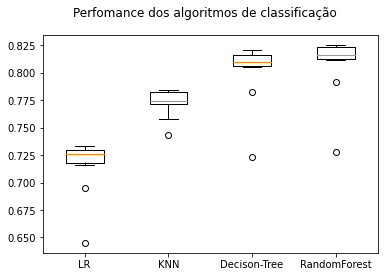

In [12]:
fig = plt.figure()
fig.suptitle('Perfomance dos algoritmos de classificação')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

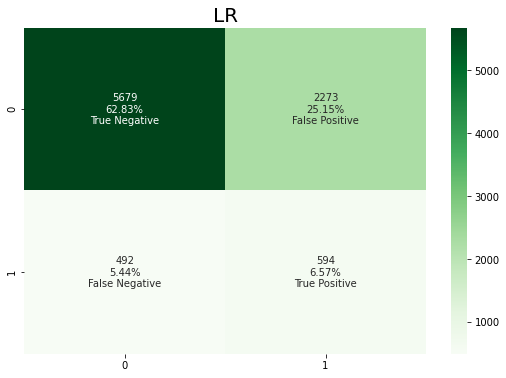

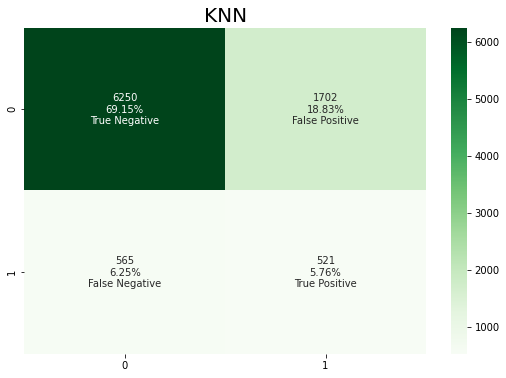

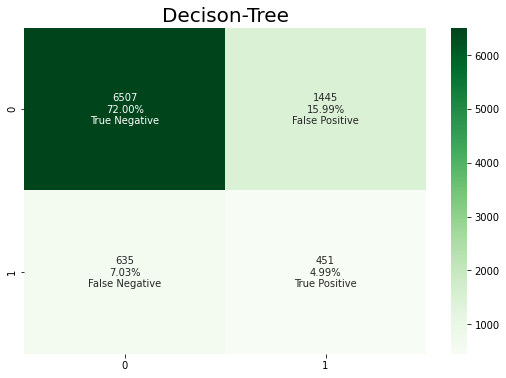

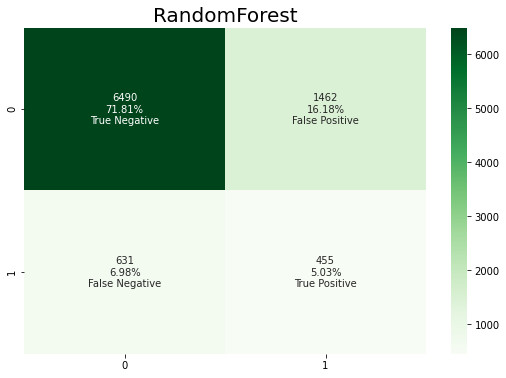

In [13]:
for name, model in models:
    y_pred = model.predict(X_test)
    conf = confusion_matrix(y_test, y_pred)

    titulo = name
    nome_quadrantes = ['True Negative','False Positive','False Negative','True Positive']
    valor_quadrantes = ["{0:0.0f}".format(value) for value in
    conf.flatten()]
    percentagem_quadrantes = ["{0:.2%}".format(value) for value in
    conf.flatten()/np.sum(conf)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
    zip(valor_quadrantes,percentagem_quadrantes,nome_quadrantes)]
    labels = np.asarray(labels).reshape(2,2)
    fig = plt.figure(figsize=(9,6))
    plt.title(titulo, fontsize =20)
    sns.heatmap(conf, annot=labels, fmt="", cmap='Greens')
    plt.show()

In [14]:
fig = go.Figure()
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    proba = cross_val_predict(model, data_x, data_y, cv = kfold, n_jobs=-1, method='predict_proba')
    prob_prediction = proba[:,1]
    fpr, tpr, _ = roc_curve(data_y, prob_prediction)
    auc = roc_auc_score(data_y, prob_prediction)
    fig.add_trace(go.Scatter(x = fpr, y = tpr, name = name + ": AUROC = %.2f" % auc))
    
fig.show()